In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

# Outliers (level)

In [115]:
def rej_rate_outliers(outlier, n_ls, eps_ls, nreps, eps0, dim=1, alpha=0.05):
    res = {oo: {kk: {
        "tilted": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "rbf": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "tilted_ol_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
        "tilted_ball_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
    } for kk in eps_ls} for oo in n_ls}
    res["eps_ls"] = eps_ls
    
    for n in n_ls:
        for eps in eps_ls:
            key = eps
            print("key:", key)
            ###
            mean1 = np.zeros((dim,)) # data
            mean2 = np.zeros((dim,)) # model
            
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
            n_outlier = max(1, int(n * eps))
            Xs[:, :n_outlier] = outlier
        
            score_fn = lambda x: - (x - mean2)
            ###
    
            # tilted
            score_weight_fn = kernels.PolyWeightFunction()
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

            ksd = metrics.KSD(kernel, score_fn=score_fn)
            wild_boot = boot.WildBootstrap(ksd)
            for X in tqdm(Xs):                
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["tilted"]["stat"].append(stat)
                res[n][key]["tilted"]["pval"].append(pval)
                res[n][key]["tilted"]["rej"].append(int(pval < alpha))
                res[n][key]["tilted"]["boot_stats"].append(boot_stats)
        
            # RBF
            kernel = kernels.RBF(sigma_sq=2.)
            
            ksd = metrics.KSD(kernel, score_fn=score_fn)
            wild_boot = boot.WildBootstrap(ksd)
            for X in tqdm(Xs):                
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["rbf"]["stat"].append(stat)
                res[n][key]["rbf"]["pval"].append(pval)
                res[n][key]["rbf"]["rej"].append(int(pval < alpha))
                res[n][key]["rbf"]["boot_stats"].append(boot_stats)

            # tilted ol robust
            score_weight_fn = kernels.PolyWeightFunction()
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

            ksd = metrics.KSD(kernel, score_fn=score_fn)
            threshold = ksd.test_threshold(n=n, eps0=eps, alpha=alpha, method="ol_robust")
            for X in tqdm(Xs):
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ol_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ol_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ol_robust"]["rej"].append(int(stat > threshold))

            # tilted ball robust
            score_weight_fn = kernels.PolyWeightFunction()
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

            ksd = metrics.KSD(kernel, score_fn=score_fn)
            threshold = ksd.test_threshold(n=n, eps0=eps0, theta="ol", alpha=alpha, method="ball_robust")
            for X in tqdm(Xs):
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ball_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ball_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ball_robust"]["rej"].append(int(stat > threshold))
                
    return res

In [116]:
np.random.seed(2024)

n = 500
n_ls = [n] # [100, 500, 1000]
eps_ls = [0.1, 0.05, 0.01, 0.005] # [0.01, 0.1]

In [117]:
outlier_ls = [0.1, 1., 10., 100.]
eps0 = 0.1
res_ol = {}
for outlier in outlier_ls:
    sub_res_ol = rej_rate_outliers(outlier, n_ls, eps_ls, eps0=eps0, nreps=100)
    res_ol[outlier] = sub_res_ol

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

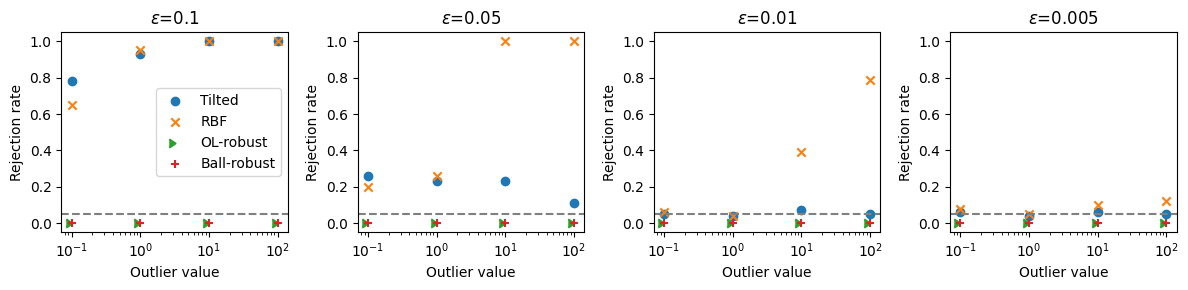

In [118]:
figs, axes = plt.subplots(ncols=len(eps_ls), nrows=1, figsize=(3*len(eps_ls), 3))

# outlier_ls = outlier_ls[::-1]
for j in range(len(eps_ls)):
    ax = axes[j]
    rej_tilted = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted"]["rej"]) for ww in outlier_ls])
    rej_rbf = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["rbf"]["rej"]) for ww in outlier_ls])
    rej_ol_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ol_robust"]["rej"]) for ww in outlier_ls])
    rej_ball_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ball_robust"]["rej"]) for ww in outlier_ls])

    ax.scatter(outlier_ls, rej_tilted, label="Tilted")
    ax.scatter(outlier_ls, rej_rbf, label="RBF", marker="x")
    ax.scatter(outlier_ls, rej_ol_robust, label="OL-robust", marker=5)
    ax.scatter(outlier_ls, rej_ball_robust, label="Ball-robust", marker="+")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_title(rf"$\epsilon$={eps_ls[j]}")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("Rejection rate")
    ax.set_xlabel("Outlier value")

axes.flatten()[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol.pdf")

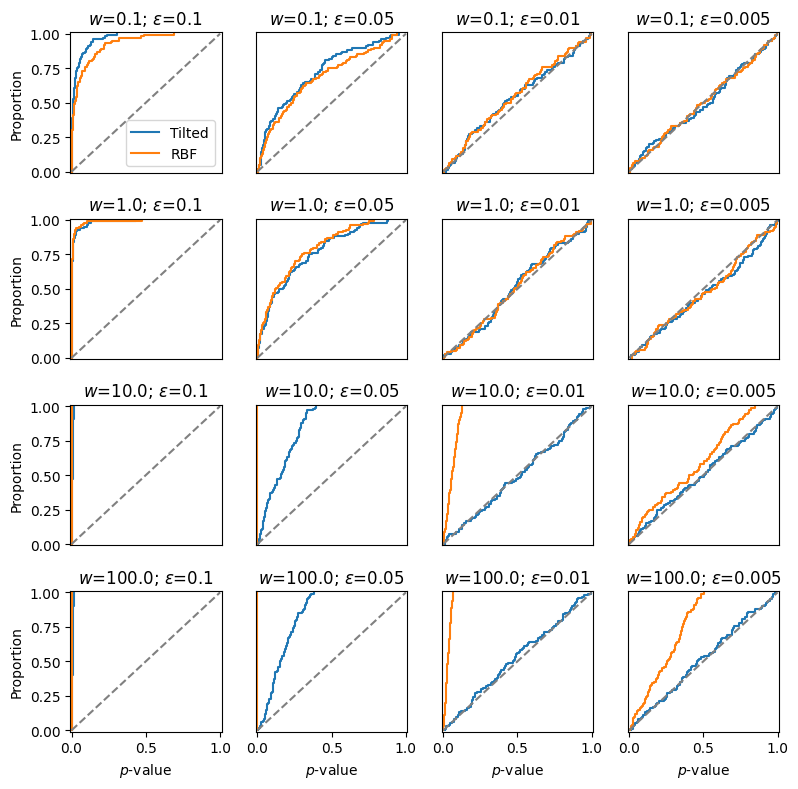

In [45]:
figs, axes = plt.subplots(ncols=len(eps_ls), nrows=len(outlier_ls), figsize=(2*len(eps_ls), 2*len(outlier_ls)))

# outlier_ls_plot = outlier_ls[::-1]
for i in range(len(outlier_ls_plot)):
    for j in range(len(eps_ls)):
        ax = axes[i][j]
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["tilted"]["pval"]), label="Tilted")
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["rbf"]["pval"]), label="RBF")
        ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-0.01, 1.01)
        ax.set_title(rf"$w$={outlier_ls_plot[i]}; $\epsilon$={eps_ls[j]}")
        ax.set_ylabel("")
        ax.set_xlabel("")
        
        if i < len(outlier_ls) - 1:
            ax.get_xaxis().set_ticks([])
        if j > 0:
            ax.get_yaxis().set_ticks([])
        if j == 0:
            ax.set_ylabel("Proportion")
        if i == len(outlier_ls) - 1:
            ax.set_xlabel(r"$p$-value")
        # if j == len(eps_ls) - 1:
        #     ax.twinx().set_ylabel(f"eps={eps_ls[j]}")
        #     ax.twinx().get_yaxis().set_ticks([])

axes.flatten()[0].legend(loc="lower right")
plt.tight_layout()

# Mean-shift (power)

In [119]:
def rej_rate_meanshift(mean_ls, n_ls, nreps, eps0, dim=1, alpha=0.05):
    res = {nn: {kk: {
        "tilted": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "rbf": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "tilted_ol_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
        "tilted_ball_robust": {"nonsq_stat": [], "threshold": [], "rej": [], "theta": []},
    } for kk in mean_ls} for nn in n_ls}
    res["mean_ls"] = eps_ls
    
    for n in n_ls:
        for mean in mean_ls:
            key = mean
            print("key:", key)
            ###
            mean1 = np.zeros((dim,)) # data
            mean2 = np.reshape([mean], (-1,)) # model
            
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
        
            score_fn = lambda x: - (x - mean2)
            ###
    
            # tilted
            score_weight_fn = kernels.PolyWeightFunction()
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

            ksd = metrics.KSD(kernel, score_fn=score_fn)
            wild_boot = boot.WildBootstrap(ksd)
            for X in tqdm(Xs):                
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["tilted"]["stat"].append(stat)
                res[n][key]["tilted"]["pval"].append(pval)
                res[n][key]["tilted"]["rej"].append(int(pval < alpha))
                res[n][key]["tilted"]["boot_stats"].append(boot_stats)
        
            # RBF
            kernel = kernels.RBF(sigma_sq=2.)
            
            ksd = metrics.KSD(kernel, score_fn=score_fn)
            wild_boot = boot.WildBootstrap(ksd)
            for X in tqdm(Xs):                
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["rbf"]["stat"].append(stat)
                res[n][key]["rbf"]["pval"].append(pval)
                res[n][key]["rbf"]["rej"].append(int(pval < alpha))
                res[n][key]["rbf"]["boot_stats"].append(boot_stats)

            # tilted ol robust
            score_weight_fn = kernels.PolyWeightFunction()
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

            ksd = metrics.KSD(kernel, score_fn=score_fn)
            threshold = ksd.test_threshold(n=n, eps0=eps0, alpha=alpha, method="ol_robust")
            res[n][key]["tilted_ol_robust"]["threshold"].append(threshold)
            for X in tqdm(Xs):
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ol_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ol_robust"]["rej"].append(int(stat > threshold))
                
            # tilted ball robust
            score_weight_fn = kernels.PolyWeightFunction()
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

            ksd = metrics.KSD(kernel, score_fn=score_fn)
            threshold = ksd.test_threshold(n=n, eps0=eps0, theta="ol", alpha=alpha, method="ball_robust")
            res[n][key]["tilted_ball_robust"]["threshold"].append(threshold)
            res[n][key]["tilted_ball_robust"]["theta"].append(ksd.theta)
            for X in tqdm(Xs):
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ball_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ball_robust"]["rej"].append(int(stat > threshold))                
    
    return res

In [120]:
def population_ksd_ms(mean, bandwidth_sq=1.):
    """Non-squared KSD"""
    mu = np.reshape([mean], (-1,))
    d = mu.shape[0]
    mu_norm = np.sqrt(np.sum(mu**2))
    return (bandwidth_sq / (bandwidth_sq + 2))**(d/4) * mu_norm

def inverse_population_ksd_ms(val, dim, bandwidth_sq=1.):
    """val is the non-squared KSD"""
    mu_norm = val * (bandwidth_sq / (bandwidth_sq + 2))**(-dim/4)
    return mu_norm

In [121]:
np.random.seed(2024)

n = 500
n_ls = [n]
# mean_ls = [0.1, 1., 10., 100.]
mean_ls = [0., 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1.]

eps0 = 0.1 # 0.01

In [ ]:
res_ms = rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, eps0=eps0, nreps=100)

key: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

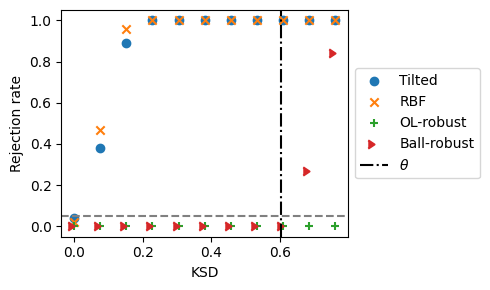

In [138]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust", marker=5)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["threshold"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("../figs/robust/rej_ms.pdf")

# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))
# ksd_val = [np.mean(res_ms[n][kk]["rbf"]["stat"])**0.5 for kk in mean_ls]
# ksd_val_pred = [population_ksd_ms(mm) for mm in mean_ls]
# ax.scatter(mean_ls, ksd_val, label="empirical")
# ax.scatter(mean_ls, ksd_val_pred, marker="x", label="pred")
# # ax.set_xscale("log")
# ax.legend()

# plt.tight_layout()

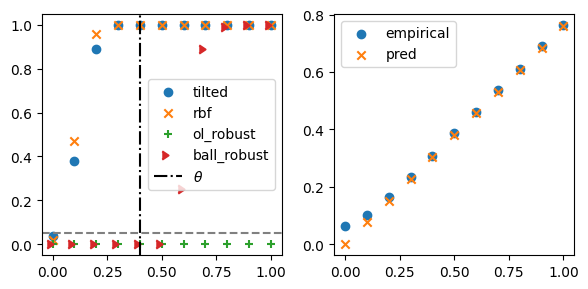

In [111]:
figs, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))

ax = axes[0]
rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])

ax.scatter(mean_ls, rej_tilted, label="tilted")
ax.scatter(mean_ls, rej_rbf, label="rbf", marker="x")
ax.scatter(mean_ls, rej_ol_robust, label="ol_robust", marker="+")
ax.scatter(mean_ls, rej_ball_robust, label="ball_robust", marker=5)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["threshold"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.legend()

ax = axes[1]
ksd_val = [np.mean(res_ms[n][kk]["rbf"]["stat"])**0.5 for kk in mean_ls]
ksd_val_pred = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(mean_ls, ksd_val, label="empirical")
ax.scatter(mean_ls, ksd_val_pred, marker="x", label="pred")
# ax.set_xscale("log")
ax.legend()

plt.tight_layout()